# Analyzing virtual tfSF using the principles of Information Bottleneck (Simulation 1)

In this notebook we re-run a simulation similar to Simulation 8.1 using a higher number of data samples.

## Setup

We start by importing some libraries:

In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

import tfSF
import npSF

import data.data_creation as D
from IT import IT

We define the parameters of our simulation:

In [2]:
learned_features = 10
n_samples = 100
n_epochs = 200

IT_bins=30

We define a couple of helper functions: a simple linear regression function and a helper function to compute the tfSF learned representation as a function of the weights. Notice that here, for simplicity, we call the steps of SF implemented using *numpy*; since no learning is now required, using *numpy* saves us the overhead of instantiating a *tensorflow* model.

In [3]:
def linreg(x,y):
    a, b, _, _, _ = stats.linregress(x,y)
    return a*x+b
    

def computeZ(X,W):
    WX = np.dot(W,X.T)
    F = npSF.softabsolute(WX)
    Fsquish, _ = npSF.l2row(F)
    Fhat, _ = npSF.l2row(Fsquish.T)
    Z = Fhat
    return Z

## Simulation 1

We now train a SF module and we evaluate the mutual information wrt to different possible labelling of the data. Specifically, we load random data togethere with three possible labelling: *Gaussian, radial, random*.

In [4]:
X, Y_gaussian, Y_radial, Y_random = D.get_samples_virtualSF(n_samples=n_samples)

We plot the data to provide an understanding of the data points and the labels.

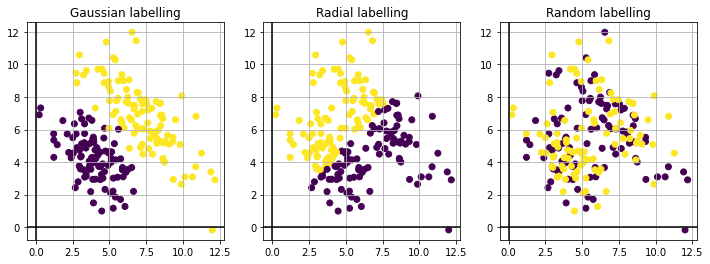

In [5]:
labels = [Y_gaussian, Y_radial, Y_random]
titles = ['Gaussian labelling', 'Radial labelling', 'Random labelling']
_, ax = plt.subplots(1,3,figsize=(12,4))

for i in range(len(labels)):
    ax[i].axhline(0,color='black')
    ax[i].axvline(0,color='black')
    ax[i].grid(True)
    ax[i].scatter(X[:,0],X[:,1], c=labels[i])
    ax[i].set_title(titles[i])

We train the SF module.

In [6]:
tfsf = tfSF.SFilter(n_features=learned_features)
tfsf.fit(X, epochs=n_epochs, batchsize=n_samples*2)

Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 587.3711
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 585.0651
Epoch 3/200
1/1 [==============================] - 0s 4ms/step - loss: 577.2848
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 575.7054
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 570.1339
Epoch 6/200
1/1 [==============================] - 0s 7ms/step - loss: 566.0875
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 562.0281
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 558.5995
Epoch 9/200
1/1 [==============================] - 0s 3ms/step - loss: 558.9091
Epoch 10/200
1/1 [==============================] - 0s 5ms/step - loss: 558.7098
Epoch 11/200
1/1 [==============================] - 0s 2ms/step - loss: 557.9811
Epoch 12/200
1/1 [==============================] - 0s 3ms/step - loss: 555.7441
Epoch 13/200
1/1 [===================

1/1 [==============================] - 0s 5ms/step - loss: 553.3570


We plot the loss function to verify that the model converged to a solution.

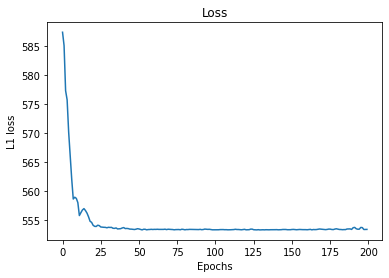

In [7]:
plt.title('Loss'); 
plt.xlabel('Epochs'); 
plt.ylabel('L1 loss');
    
plt.plot(tfsf.hist.history['loss'])

We compute the mutual information of the learned representations and the different types of labelling.

In [8]:
Ws = tfsf.weights

MI_gaussian = []; MI_radial = []; MI_random = []
  
for W in Ws:
    Z = computeZ(X,W)
    
    MI_gaussian.append(IT.compute_MI_dd_bin(Z,Y_gaussian,n_bins=IT_bins))
    MI_radial.append(IT.compute_MI_dd_bin(Z,Y_radial,n_bins=IT_bins))
    MI_random.append(IT.compute_MI_dd_bin(Z,Y_random,n_bins=IT_bins))

We plot entropy and mutual information.

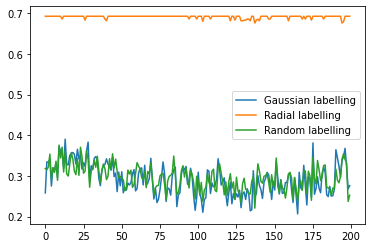

In [9]:
mis = [MI_gaussian, MI_radial, MI_random]
titles = ['Gaussian labelling', 'Radial labelling', 'Random labelling']

for i in range(len(mis)):
    plt.plot(mis[i],label=titles[i])
plt.legend()

## Conclusions

- Results on MI seems to hold even more strongly for a higher-dimensional learned space.

### References

[1] Zennaro, F.M. and Chen, K., 2019. Towards Further Understanding of Sparse Filtering via Information Bottleneck. arXiv preprint arXiv:1910.08964.